# Data source

Data for download: https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz

Resources used as reference:
1) Training the image classifier to recognize different species of flowers:
https://www.kaggle.com/dtosidis/flower-classifier-tensorflow
  
2) Loading and preprocessing an image dataset
https://www.tensorflow.org/tutorials/load_data/images

3) Data augmentation
https://www.tensorflow.org/tutorials/images/data_augmentation

4) Image classification
https://www.tensorflow.org/tutorials/images/classification


In [1]:
!conda info


     active environment : Mlearning
    active env location : C:\ProgramData\Anaconda3\envs\Mlearning
            shell level : 2
       user config file : C:\Users\nairs\.condarc
 populated config files : C:\Users\nairs\.condarc
          conda version : 4.8.3
    conda-build version : 3.18.11
         python version : 3.7.6.final.0
       virtual packages : __cuda=10.2
       base environment : C:\ProgramData\Anaconda3  (read only)
           channel URLs : https://repo.anaconda.com/pkgs/main/win-64
                          https://repo.anaconda.com/pkgs/main/noarch
                          https://repo.anaconda.com/pkgs/r/win-64
                          https://repo.anaconda.com/pkgs/r/noarch
                          https://repo.anaconda.com/pkgs/msys2/win-64
                          https://repo.anaconda.com/pkgs/msys2/noarch
          package cache : C:\ProgramData\Anaconda3\pkgs
                          C:\Users\nairs\.conda\pkgs
                          C:\Users\nairs\A

In [2]:
!conda list

# packages in environment at C:\ProgramData\Anaconda3\envs\Mlearning:
#
# Name                    Version                   Build  Channel
absl-py                   0.10.0                   pypi_0    pypi
aiohttp                   3.6.2                    pypi_0    pypi
argon2-cffi               20.1.0           py38he774522_1  
astroid                   2.4.2                    pypi_0    pypi
astunparse                1.6.3                    pypi_0    pypi
async-timeout             3.0.1                    pypi_0    pypi
async_generator           1.10                       py_0  
attrs                     20.2.0                     py_0  
backcall                  0.2.0                      py_0  
blas                      1.0                         mkl  
bleach                    3.2.1                      py_0  
ca-certificates           2020.7.22                     0  
cachetools                4.1.1                    pypi_0    pypi
certifi                   2020.6.20          

In [3]:
# !pip install keras

In [4]:
!pip install scikit-learn

In [1]:
# Dependencies
import matplotlib.pyplot as plt
%matplotlib inline

import os
import numpy as np
import tensorflow as tf

import PIL
import PIL.Image

import pathlib

os.environ['KMP_DUPLICATE_LIB_OK']='True'

from tensorflow import keras
from tensorflow.keras.preprocessing import image
import tensorflow_hub as hub

from keras.datasets import mnist
from keras.layers.core import Dense, Dropout, Activation
from keras.models import Sequential

from tensorflow.keras.applications.vgg19 import (
    VGG19, 
    preprocess_input, 
    decode_predictions
)

#New method for test train split

from sklearn.model_selection import train_test_split



In [2]:
!pwd

/c/ShankersDocs/EDUCATION/RICE_Bootcamp_DataAnalytics/FinalProject_Img_Recognition_Flowers/Final_RICEproject_ImageRecognition_flowers


### Total images in the dataset

In [3]:
data_dir = 'flower_photos'
data_dir = pathlib.Path(data_dir)
image_count = len(list(data_dir.glob('*/*.jpg')))
# print(image_count)

## Image Classification
https://www.tensorflow.org/tutorials/images/classification?hl=zh-tw

## Hyperparameters of the model

### Batch Size
* 32, 64, 128

### Epochs
* From 1 to 100
* We will use accuracy score on the validation data to find the best epoch

* We will use the accuracy score on the validation data to find the best hyperparameter of the model
* Once we find the best hyperparameter of the model. we train the model using that hyperparameter and then estimate the model performance on the test data

In [4]:
batch_size = 32
img_height = 180
img_width = 180

## Generating datasets
https://keras.io/examples/vision/image_classification_from_scratch/

### Generating a training dataset

In [5]:
# When the subset below is defined as "training" the 0.2 validation split takes 80% of the data as the training set

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  'flower_photos',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


### Generating a validation dataset

In [6]:
# When the subset below is defined as "validation" the 0.1 validation split takes 10% of the data as the validation set

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  'flower_photos',
  validation_split=0.1,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 367 files for validation.


### Generating a test dataset

In [7]:
# When the subset below is defined as "validation" the 0.1 validation split takes 10% of the data as the test set

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  'flower_photos',
  validation_split=0.1,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 367 files for validation.


### Class names

In [8]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


### Rescaling the data
https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Rescaling


In [9]:
from tensorflow.keras import layers

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

### Normalizing the data (trainign and validation datasets)

In [10]:
normalized_train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
normalized_val_ds =  val_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_train_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 1.0


### Autotune is done to cache data and make processing and resource mgmt more effieicient

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [12]:
normalized_train_ds = normalized_train_ds.cache().prefetch(buffer_size=AUTOTUNE)
normalized_val_ds = normalized_val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [13]:
# num_classes = 5
num_classes = len(class_names)
num_classes

5

## Model 1 (Sequential Model)
https://www.tensorflow.org/guide/keras/sequential_model

## Model 2 

In [14]:
model_2 = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(128, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(64, activation='relu'),
  layers.Dense(num_classes)
])

In [15]:
model_2.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [16]:
EPOCHS = 20

In [17]:
history = model_2.fit(train_ds,validation_data= val_ds, epochs=EPOCHS)

Epoch 1/20
92/92 [==============================] - 145s 2s/step - loss: 1.3663 - accuracy: 0.3886 - val_loss: 1.1512 - val_accuracy: 0.4986
Epoch 2/20
92/92 [==============================] - 158s 2s/step - loss: 1.0594 - accuracy: 0.5715 - val_loss: 0.9801 - val_accuracy: 0.6185
Epoch 3/20
92/92 [==============================] - 161s 2s/step - loss: 0.8923 - accuracy: 0.6584 - val_loss: 0.9376 - val_accuracy: 0.6049
Epoch 4/20
92/92 [==============================] - 170s 2s/step - loss: 0.7065 - accuracy: 0.7354 - val_loss: 0.9540 - val_accuracy: 0.6594
Epoch 5/20
92/92 [==============================] - 160s 2s/step - loss: 0.5262 - accuracy: 0.8059 - val_loss: 1.0843 - val_accuracy: 0.6022
Epoch 6/20
92/92 [==============================] - 159s 2s/step - loss: 0.3763 - accuracy: 0.8689 - val_loss: 1.1917 - val_accuracy: 0.6104
Epoch 7/20
92/92 [==============================] - 155s 2s/step - loss: 0.3382 - accuracy: 0.8764 - val_loss: 1.2957 - val_accuracy: 0.6431
Epoch 8/20
92

In [18]:
model_2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 178, 178, 128)     3584      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 89, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 87, 87, 64)        73792     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 43, 43, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 41, 41, 32)        18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 20, 20, 32)        0

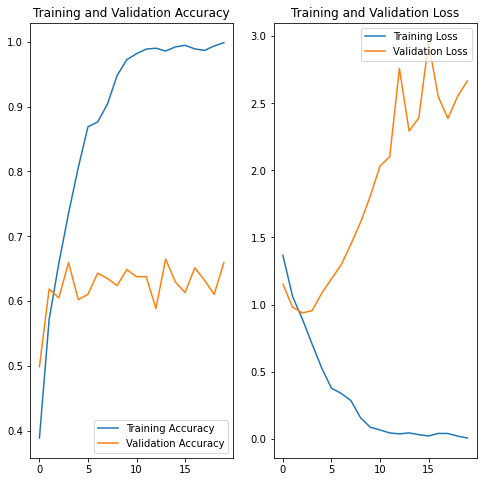

In [19]:
# TODO: Plot the loss and accuracy values achieved during training for the training and validation set.
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
# plt.savefig('ML_output_plots/epoch_10.png')

### Plot it and then take the epoch where you get the maximum validation accuracy
* This iwould be hyperparameter tuning of the epochs

## Model perofrmance on the test data
* This is done at the end after you have completed hyperparamter tuning

In [ ]:
results = model_2.evaluate(test_ds)
print('test loss, test acc:', results)